# Force-directed graph visualisation

This notebook visualises the molecules using a force-directed graph layout,
so that the distances between each molecule (a point on the graph) are determined
as though they were connected by springs with a spring constant given by the kernel function.

In [1]:
import re

import matplotlib.pyplot as plt
import molplotly
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.offline as py
import seaborn as sns
from fa2 import ForceAtlas2


First we load the data.

In [2]:
kernel_df = pd.read_csv("full_kernel.csv")
kernel_mat = kernel_df.loc[:, "K0":].values

In [3]:
def get_counterion(smiles: str) -> str:
    """Get the counterion for a smiles string"""
    pattern = r"\.(?P<counterion>\S+)"
    match = re.search(pattern, smiles)
    if match:
        counterion = match.group("counterion")
        if "." in counterion:
            return "Complex"
        else:
            return counterion
    else:
        return "Nonionic"

In [4]:
def add_cols(df: pd.DataFrame):
    df["Counterion"] = df["SMILES"].apply(get_counterion)
    df["Source"] = ["Qin" if pd.isna(convertable) else "NIST" for convertable in df["Convertable"]]

In [5]:
add_cols(kernel_df)

Now we compute the positions and add them to the dataframe.

In [6]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False, # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=2.0,
    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED
    # Tuning
    scalingRatio=2.0,
    strongGravityMode=True,
    gravity=1.0,
    # Log
    verbose=True,
)

In [7]:
positions = forceatlas2.forceatlas2(kernel_mat, iterations=2000)

100%|██████████| 2000/2000 [00:12<00:00, 154.85it/s]

BarnesHut Approximation  took  0.86  seconds
Repulsion forces  took  3.83  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  7.82  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


In [8]:
positions = np.array(positions)
positions.shape

(245, 2)

In [9]:
kernel_df["Force X"] = positions[:, 0]
kernel_df["Force Y"] = positions[:, 1]

Lastly, we plot the data!

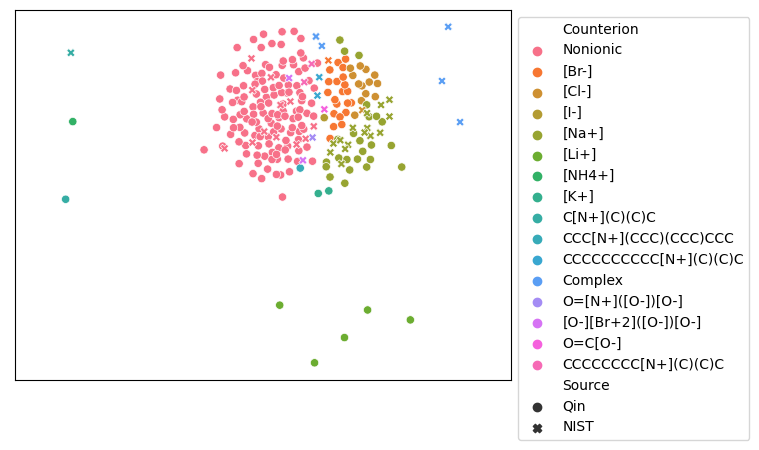

In [15]:
fg = sns.scatterplot(
    kernel_df, x="Force X", y="Force Y", hue="Counterion", style="Source"
)
fg.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
plt.axis("equal")
ax = plt.gca()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [11]:
fig = px.scatter(kernel_df, x="Force X", y="Force Y", color="Counterion")
fig.update_layout(width=1000, height=1000)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig["layout"].update(scene=dict(aspectmode="data"))
app = molplotly.add_molecules(fig=fig, df=kernel_df, smiles_col="SMILES", color_col="Counterion")
app.run_server(mode="inline", port=8700)
# py.iplot(fig, filename='stacked-bar')

c:\Users\Alexander\anaconda3\envs\camcann\lib\site-packages\molplotly\main.py:32: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

c:\Users\Alexander\anaconda3\envs\camcann\lib\site-packages\molplotly\main.py:76: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

